# Replicating Laurenti et al.'s autoregressive forecast of p4581 with an LTSM

*Note: comments have been added to Laurenti's code using ChatGPT to assist with understanding*

## Intro & Context

Experiment p4581 has over 5000 seconds of data, although the useful data is between approximately 2000-4700 seconds. The experiment starts with a normal stress of 2 MPa, increasing in 1 MPa steps up to 8 MPa and back down again. Laurenti uses the segment of the experiment where normal stress = 8 MPa (see extract from p53 of the supplementary material, below). Note that this is different to the segment provided in Adriano's data loader, which extracts data from the beginning of the experiment where normal stress = 2 MPa. For more analysis on how the p4581 data varies with normal stress, see notebook ["TRR26 002 - Data Exploration - p4581.ipynb"](TRR26%20002%20-%20Data%20Exploration%20-%20p4581.ipynb).

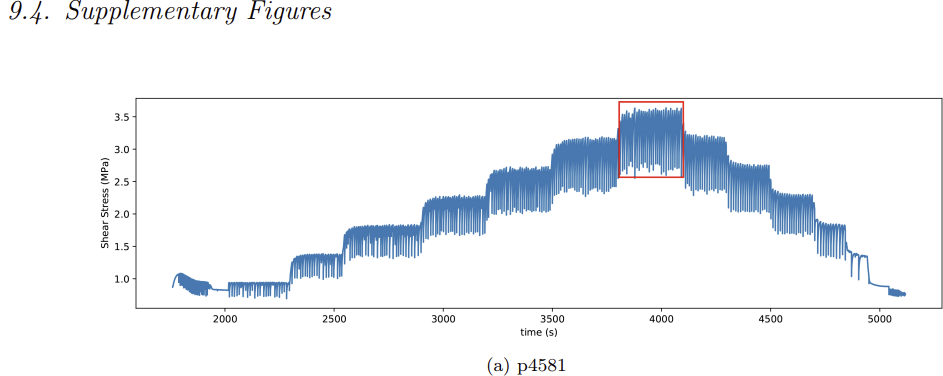

While Laurenti et al. do not specify the exact time segment used in their analysis, it can be deduced that it is between 3800 and 4100 seconds based on the following extract p54 of the supplementary material. This chart is accurately replicated using 3800-4100 seconds further down this notebook.

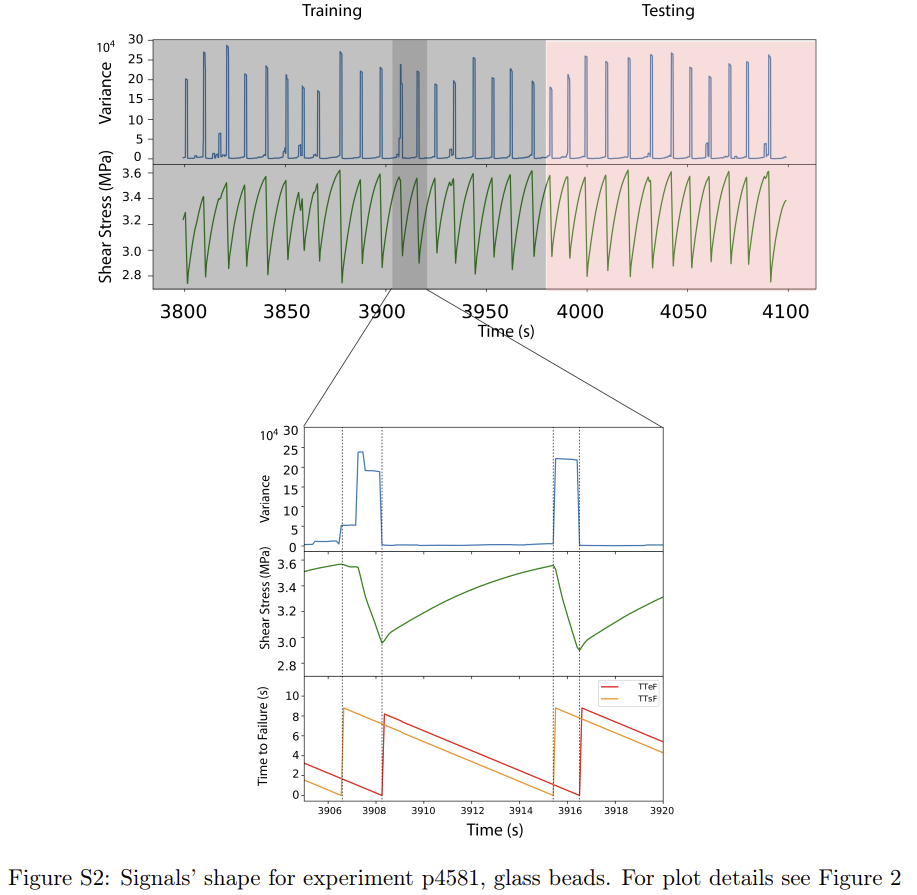

Note that  experiment is transitioning out of 8 MPa normal stress at the beginning and end of this time segment (see extract from analysis in ["TRR26 002 - Data Exploration - p4581.ipynb"](TRR26%20002%20-%20Data%20Exploration%20-%20p4581.ipynb)). Best practice would be to trim the ends so that the normal stress is stable. But we'll use it for now.

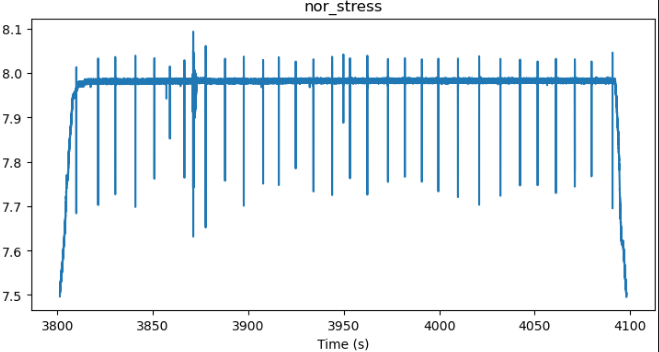

## Imports and data loading

Set the variable *jasmin* to True if you're running from the GTC setup on JASMIN. Otherwise, set *jasmin* to False and update the *MAIN_DIR*, *DATA_DIR* and *p4581_FILE_PATH* paths as appropriate.

In [1]:
# Set Directories

jasmin = True  # Set to True if running on JASMIN, False if on local machine
jasmin_user_name = "trr26"

if jasmin:
    MAIN_DIR = f"/gws/nopw/j04/ai4er/users/{jasmin_user_name}/earthquake-predictability"
    DATA_DIR = f"{MAIN_DIR}/data/gtc_quakes_data"

else:   # update directory names to match your local machine
    MAIN_DIR = f"/home/tom-ratsakatika/VSCode/earthquake-predictability"
    DATA_DIR = f"{MAIN_DIR}/data_local/gtc_quakes_data"

p4581_FILE_PATH = f"{DATA_DIR}/labquakes/Marone/p4581/p4581.txt"

# Imports

import os
import random
import sys
from math import sqrt

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from IPython.display import Image

sys.path.append(MAIN_DIR)
import utils

In [2]:
# Check CUDA Availability

if torch.cuda.is_available():
    dev = "cuda"
    map_location = None
    print(f"Total number of GPUs available: {torch.cuda.device_count()}")
    !nvidia-smi
else:
    dev = "cpu"
    map_location = "cpu"
    print("No GPU available.")
device = torch.device(dev)

Total number of GPUs available: 4
Thu Feb  8 17:38:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   30C    P0              53W / 400W |      8MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------------------------------

,time,lp_disp,shr_stress,nor_disp,nor_stress,sync,samp_freq
0,1.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
1,2.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
2,3.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
3,4.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
4,5.0,0.0,0.0,-0.0,1.000000e-18,3.29855,1


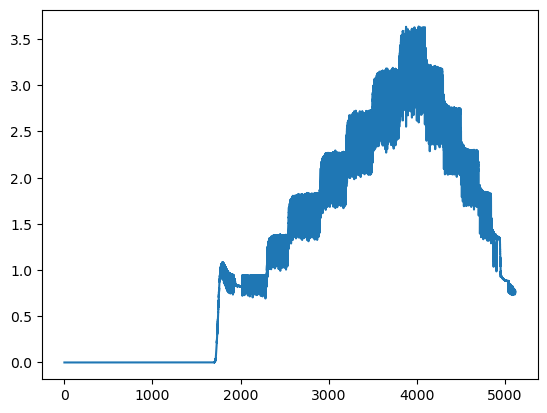

In [3]:
# Open the file located at p4581_FILE_PATH in read mode
with open(p4581_FILE_PATH, "r") as file:
    # Read the file as a CSV using pandas, considering whitespace as delimiter
    # Skip the first 4 rows as they do not contain relevant data
    df = pd.read_csv(file, delim_whitespace=True, skiprows=4)

# Rename the columns of the DataFrame to align with the variable names used by Adriano's data loader
df.columns = [
    "id",            # Identifier
    "lp_disp",       # Lateral displacement
    "shr_stress",    # Shear stress
    "nor_disp",      # Normal displacement
    "nor_stress",    # Normal stress
    "time",          # Time of measurement
    "sync",          # Synchronization marker
    "samp_freq",     # Sampling frequency
]

# Drop the 'id' column as it's not needed for further analysis
df = df.drop(["id"], axis=1)

# Reorder the DataFrame columns to bring 'time' to the front
df = df[["time"] + [col for col in df.columns if col != "time"]]

# Plotting shear stress against time using matplotlib
plt.plot(df["time"], df["shr_stress"])

# Display the first 5 rows of the DataFrame
df.head()

In [4]:
# Define a function to perform first-order polynomial detrending - note that we don't use this initially

def detrend_first_order_poly(x, y):
    # Fit a first-degree polynomial to the data (linear fit)
    # 'p' contains the coefficients of the polynomial (slope and intercept)
    p = np.polyfit(x, y, deg=1)

    # Detrend the data by subtracting the linear trend component
    # This is done by calculating p[0] * x + p[1], which represents the linear trend,
    # and then subtracting this from the original y values
    y_det = y - (p[0] * x + p[1])

    # Return the detrended y values
    return y_det

## Define the time segment and visualise the data

In [5]:
# Define start and end times for the data selection
start_time = 3800
end_time = 4099.99  # adjusted slightly so that the size of the dataframe can be divided exactly by 100. this is necessary due to a oddity of Laurenti's createsubwindow function

# time_range = (df["time"] >= start_time) & (df["time"] <= end_time)#
# time = df.loc[time_range, "time"]
# shear_stress = df.loc[time_range, "shr_stress"]
# y_det = detrend_first_order_poly(x, y)

# Filter the original DataFrame 'df' to include only rows within the specified time range
filtered_data = df[(df["time"] >= start_time) & (df["time"] <= end_time)]

# Select only the 'shr_stress' and 'time' columns from the filtered data,
# create a copy of this selection, and convert their data types to float32
df = (
    filtered_data[["shr_stress", "time"]]
    .copy()
    .astype({"shr_stress": "float32", "time": "float32"})
)

# Reset the index of the DataFrame to ensure it starts from 0 for the new subset of data
# and drop the old index
df = df.reset_index(drop=True)

# Display the first few rows of the newly filtered and processed DataFrame
df.head()

,shr_stress,time
0,3.28402,3800.0
1,3.28402,3800.0
2,3.28385,3800.0
3,3.28390,3800.0
4,3.28384,3800.0


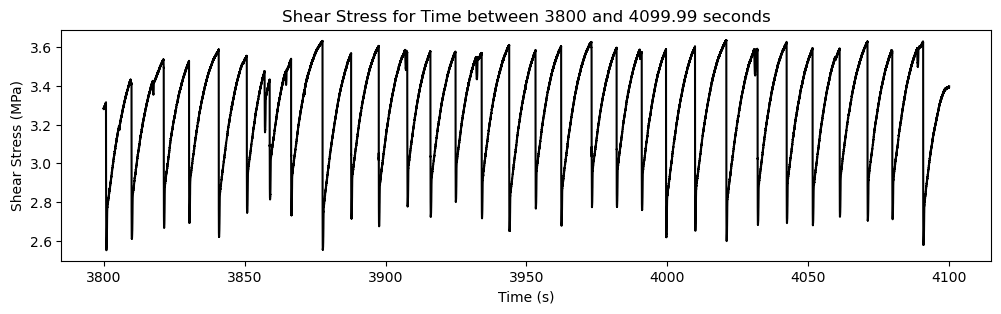

In [6]:
# Plot 'time' vs 'shr_stress' from the DataFrame 'df'

plt.figure(figsize=(12, 3))
plt.plot(df["time"], df["shr_stress"], "k")
plt.xlabel("Time (s)")
plt.ylabel("Shear Stress (MPa)")
plt.title(f"Shear Stress for Time between {start_time} and {end_time} seconds")
plt.show()

Note the near exact match with the chart above from supplementary material, suggesting that we have the correct time segment. The minimum value of some troughs appear lower in our graph, although this could be due to rendering differences. **To do: check minimum points match.**

## Data pre-processing

The first thing Laurenti et al. do is min-max scaling (sklearn pre-processing) and then data smoothing/downsampling using her own function.

**Comment: predicting smoothed data is presumably an easier task - do we want to do the same?**

First we do Mix-Max Scaling...

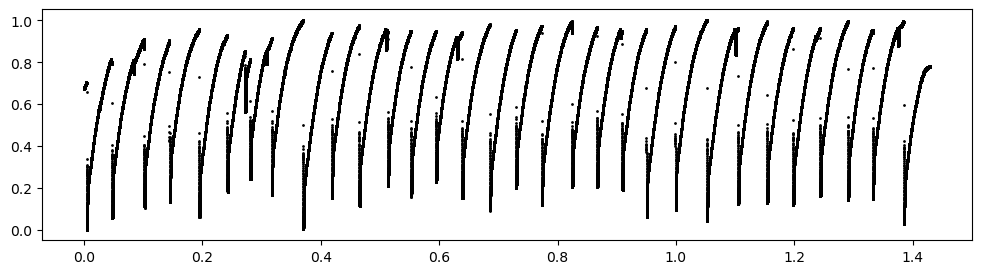

Shape of x_scaled: (300000, 2)


In [7]:
### Min-Max Scaling ###

# Create a MinMaxScaler object from sklearn.preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

# Select a portion of the DataFrame 'df' (70%) to be used for scaling
x = df[: int(len(df) * 0.7)].values  # Selecting the first 70% of rows

# Fit the MinMaxScaler to the selected portion of data
# This calculates the min and max values to be used for scaling
min_max_scaler.fit(x)

# Apply the MinMax scaling to the entire DataFrame 'df'
# Note: This uses the scale computed on the 70% of the data to transform
# the full dataset, aligning with best practice (no information leakage
# to the test set)
x_scaled = min_max_scaler.transform(df.values)

# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(x_scaled)

# Plotting the scaled data
plt.figure(figsize=(12, 3))
plt.plot(df_scaled[1], df_scaled[0], ".k", markersize=2)
plt.show()

print(f"Shape of x_scaled: {x_scaled.shape}")

Then we define Laurenti's smoothing function:

- First it calculates a trimmed moving average over 1000 points, excluding outliers in the calculation of the mean.
- Then it downsamples, taking one point every n steps. But it still keeps all the data, it just creates n columns, each staggered by one time step.
- Note that this function only works properly if the length of the input can be divided by n without a remainder. Recommend we correct this.

**Comment: changing the plot so that we see the individual points (rather than an extrapolated line which is the default) gives a better intuition about how much data we lose by lowering the resolution. Specifically, it is very difficult to see TTsF and TTeF.**

In [8]:
# Laurenti's create sub-window function.


def CreateSubwindows(df, n=100):
    """Creates running windows to interpolate the DataFrame.
    It takes 1 point every n to low[er] the resolution.

    Args:
    ----------
    df : DataFrame
        Input DataFrame
    n : int (default=100)
        Number of points to take in lowering the resolution.

    Returns:
    ----------
    df : resulting DataFrame
    """


    # Apply a rolling window of size 1000 to the DataFrame and calculate the trimmed mean,
    # excluding the highest and lowest 5% of the points within each window.
    df = df.rolling(1000).apply(lambda w: scipy.stats.trim_mean(w, 0.05))

    # Discard the first 1000 points from the DataFrame as they are based on a partial rolling window
    df = df[1000 : len(df)]

    # Reset the index of the DataFrame and drop the old index column
    df = df.reset_index().drop(["index"], axis=1)

    # Create subwindows: Reduce resolution by selecting one point every 'n' points
    subwindows = [
        list(i)
        for i in zip(
            *[
                df.values.reshape(-1)[i : i + n]
                for i in range(0, len(df.values.reshape(-1)), n)
            ]
        )
    ]
    # Convert the subwindows list to a DataFrame and transpose it
    df = pd.DataFrame(subwindows).T

    # Convert all data in DataFrame to float32 type
    df = df.apply(np.float32)

    # Plot an example of the processed data
    print("A plot of example:")
    plt.figure(figsize=(12, 3))
    plt.plot(df[40], ".k", markersize=2)
    plt.show()

    # Return the processed DataFrame
    return df

#### Comments on the Sub-Window approach

Applying Laurenti's "createsubwindow" function to the data first smooths the data using a rolling average (excluding the top and bottom 5% of values to prevent skew from outliers) and then downsamples the timeseries by taking every 100th point. However, she keeps all the data - the output of the function is a 2D dataframe with 100 columns, each staggered from the previous by one (original) time step. This enables Laurenti to train her model on all the data with a reasonable number of steps in (200) and out (100). If the original resolution was used, the number of steps in/out would need to be 20,000 and 10,000 respectively.  

A plot of example:


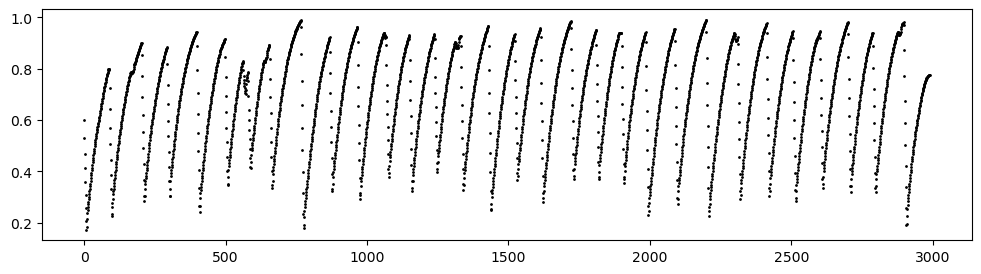

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.631091,0.630345,0.629598,0.628852,0.628106,0.627360,0.626614,0.625868,0.625122,0.624376,...,0.564862,0.564142,0.563422,0.562702,0.561983,0.561265,0.560546,0.559829,0.559112,0.558396
1,0.557680,0.556964,0.556249,0.555535,0.554820,0.554107,0.553395,0.552682,0.551971,0.551260,...,0.496814,0.496188,0.495563,0.494939,0.494317,0.493696,0.493075,0.492456,0.491838,0.491222
2,0.490607,0.489992,0.489380,0.488768,0.488158,0.487549,0.486940,0.486334,0.485728,0.485124,...,0.439533,0.438995,0.438458,0.437920,0.437382,0.436845,0.436308,0.435771,0.435233,0.434696
3,0.434159,0.433621,0.433085,0.432548,0.432011,0.431473,0.430937,0.430400,0.429863,0.429326,...,0.386196,0.385668,0.385141,0.384614,0.384086,0.383559,0.383032,0.382504,0.381977,0.381450
4,0.380922,0.380394,0.379867,0.379339,0.378812,0.378284,0.377757,0.377229,0.376702,0.376174,...,0.333847,0.333331,0.332815,0.332299,0.331783,0.331267,0.330750,0.330234,0.329717,0.329201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,0.773161,0.773172,0.773184,0.773195,0.773207,0.773218,0.773230,0.773241,0.773252,0.773264,...,0.774039,0.774050,0.774061,0.774072,0.774083,0.774094,0.774105,0.774116,0.774127,0.774138
2986,0.774149,0.774160,0.774171,0.774181,0.774192,0.774203,0.774213,0.774224,0.774234,0.774245,...,0.774940,0.774948,0.774955,0.774962,0.774969,0.774976,0.774983,0.774989,0.774996,0.775002
2987,0.775009,0.775015,0.775022,0.775029,0.775035,0.775041,0.775048,0.775055,0.775061,0.775068,...,0.775675,0.775683,0.775691,0.775699,0.775706,0.775715,0.775722,0.775730,0.775738,0.775745
2988,0.775752,0.775760,0.775768,0.775775,0.775782,0.775790,0.775797,0.775804,0.775812,0.775819,...,0.776403,0.776410,0.776418,0.776425,0.776433,0.776440,0.776448,0.776455,0.776463,0.776470


In [9]:
# Creates a new dataframe from shear stress processed using the createsubwindow function

df_smoothed = CreateSubwindows(df_scaled[0])
df_smoothed

## Initialise the functions and classes in Laurenti's 'utils.py' file

These functions and classes are extracted from Laurenti's utils.py file.

This first function, train_val_test_split, goes through a number of steps:

- First, it calculates the length of the train, validation and test sets based on the %s provided, creates a new dataframe for each and then converts the dataframe into a NumPy array (which seems a bit convoluted but it works). Note that the validation and test sets have a "steps_out" buffer. It's likely the intention of this is to use all the data, however I'm not sure why steps_out is used rather than steps_in at the beginning of the segment. There is also data leakage from the train to validation set and validation to test set with this method.

- Second, for the train, validation and test data, the code creates 300 step segments (200 in, 100 out), iterating across all the rows and columns of the input dataframe. The code then splits these segments into Xs (200 in) and ys (99 out) and labels (100 out). The shape of y is 99, not 100, which needs further investigation. Labels is used for teacher forcing in the LSTM model.

- Third, the NumPy arrays are converted into PyTorch tensors, then PyTorch Datasets, then PyToch Dataloaders. Note that the Dataloaders have the shuffle parameter set to true for the train and validation sets - this is key as it reduces the chance of the model simply learning a periodic signal. Also note that num_workers is set to zero. This should likely be increased when working on JASMIN.

In [10]:
def train_val_test_split(
    df,
    train_percentage,
    val_percentage,
    test_percentage,
    window_shift,
    batch_size,
    steps_in=200,
    steps_out=100,
):
    """
    This function splits a DataFrame into training, validation, and test sets based on specified percentages.
    It also creates sequences of data for input and output, suitable for time series forecasting models.

    Args:
    ----------
    df : DataFrame
          Input DataFrame
    train_percentage : float 0<=train_percentage<=1 (suggestion=0.7)
          Percentage of df length to use as training data.
    val_percentage : float 0<=val_percentage<=1 (suggestion=0.1)
          Percentage of df length to use as validation data.
    test_percentage : float 0<=test_percentage<=1 (suggestion=0.2)
          Percentage of df length to use as testing data.
          Note: train_percentage+val_percentage+test_percentage must be <1 and should be =1.
    window_shift : int (suggestion=10)
          Shift between one window and the following.
    batch_size : int
          Size of the batch used during the training of the model.
    steps_in : int (default=200)
          Number of points in input for the model, representing the known past.
    steps_out : int (default=100)
          Number of points in output from the model, representing the future to be forecasted.

    Returns:
    ----------
    tr_dl : torch.utils.data.DataLoader
          Resulting training set
    val_dl : torch.data.DataLoader
          Resulting validation set
    test_dl : torch.utils.data.DataLoader
          Resulting testing set

    """

    # ---------------------------------------------------------------- #

    # Calculate the length of the training set
    train_size = int(len(df) * train_percentage)      # 'dataset_train' contains the first 'train_size' number of rows from 'df'
    dataset_train = df[0:train_size]      # 'training_set' is a NumPy array containing all columns of 'dataset_train'
    training_set = dataset_train.iloc[:, 0:dataset_train.shape[1]].values     # Tom Comment: Why not just training_set = dataset_train.values?

    # Calculate the size of the validation set and extract it from the DataFrame
    # The validation set includes a 'steps_out' buffer from the training set to allow for sequence continuity
    val_size = int(len(df) * val_percentage)
    dataset_val = df[train_size - steps_out:train_size + val_size + steps_out]      # Tom Comment: why is the size of the buffer steps_out rather than in? Also information leakage a potential problem.
    val_set = dataset_val.iloc[:, 0:dataset_val.shape[1]].values

    # Calculate the size of the test set and extract it
    # The test set similarly includes a 'steps_out' buffer from the validation set
    test_size = int(len(df) * test_percentage)
    dataset_test = df[train_size + val_size - steps_out:train_size + val_size + test_size]
    test_set = dataset_test.iloc[:, 0:dataset_test.shape[1]].values

    # Print shapes of the training, validation, and test datasets for verification
    print("training_set.shape: ", training_set.shape, " val_set.shape: ", val_set.shape, " test_set.shape: ", test_set.shape)

    # ---------------------------------------------------------------- #

    # Prepare the training data
    # Loop through each column (feature) and each window in the dataset to create sequences
    df_tr = []
    for j in range(training_set.shape[1]):  # Iterating over each feature/column
        for i in range(0, training_set.shape[0] - steps_in - steps_out, window_shift):  # Iterating over each window
            # Append a sequence containing 'steps_in + steps_out' data points starting from index 'i'
            df_tr.append(training_set[:, j][i:i + steps_in + steps_out])

    # Split the training data into input (X_train) and output (y_train) sequences
    X_train, y_train, label_train = [], [], []
    for elem in df_tr:
        # The input sequence consists of the first 'steps_in' elements of the sequence
        X_train.append(np.expand_dims(elem[0:steps_in], axis=1))
        # The output sequence (y_train) consists of the following 'steps_out' elements, except the last one
        y_train.append(np.expand_dims(elem[steps_in:-1], axis=1))
        # The label sequence (label_train) consists of the full 'steps_out' elements      # Tom comment: this is used for teacher forcing
        label_train.append(np.expand_dims(elem[steps_in:], axis=1))
    X_train, y_train, label_train = np.array(X_train), np.array(y_train), np.array(label_train)

    # Print shapes of the training sequences for verification
    print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " label_train.shape: ", label_train.shape)

    # ---------------------------------------------------------------- #

    # The following code repeats the same process for the validation and test sets
    # Prepare validation data
    df_val = []
    for j in range(val_set.shape[1]):  # Iterate over each feature/column
        for i in range(0, val_set.shape[0] - steps_in - steps_out, window_shift):  # Iterate over each window
            df_val.append(val_set[:, j][i:i + steps_in + steps_out])

    X_val, y_val, label_val = [], [], []
    for elem in df_val:
        X_val.append(np.expand_dims(elem[0:steps_in], axis=1))
        y_val.append(np.expand_dims(elem[steps_in:-1], axis=1))
        label_val.append(np.expand_dims(elem[steps_in:], axis=1))
    X_val, y_val, label_val = np.array(X_val), np.array(y_val), np.array(label_val)

    # Print shapes of the validation sequences for verification
    print("X_val.shape: ", X_val.shape, " y_val.shape: ", y_val.shape, " label_val.shape: ", label_val.shape)

    # ---------------------------------------------------------------- #

    # Prepare test data
    df_test = []
    for j in range(test_set.shape[1]):  # Iterate over each feature/column in the test set
        for i in range(0, test_set.shape[0] - steps_in - steps_out, window_shift):  # Iterate over each window in the test set
            # Append a sequence containing 'steps_in + steps_out' data points starting from index 'i' for each feature
            df_test.append(test_set[:, j][i:i + steps_in + steps_out])

    # Split the test data into input (X_test) and output (y_test) sequences
    X_test, y_test, label_test = [], [], []
    for elem in df_test:
        # The input sequence consists of the first 'steps_in' elements of the sequence
        X_test.append(np.expand_dims(elem[0:steps_in], axis=1))
        # The output sequence (y_test) consists of the following 'steps_out' elements, except the last one
        y_test.append(np.expand_dims(elem[steps_in:-1], axis=1))
        # The label sequence (label_test) consists of the full 'steps_out' elements
        label_test.append(np.expand_dims(elem[steps_in:], axis=1))
    X_test, y_test, label_test = np.array(X_test), np.array(y_test), np.array(label_test)

    # Print shapes of the test sequences for verification
    print("X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape, " label_test.shape: ", label_test.shape)

    # ---------------------------------------------------------------- #

    # Convert the numpy arrays to PyTorch tensors. scr = source, trg = training, lab = label (associated with teacher forcing)
    src_train, trg_train, lab_train = torch.from_numpy(X_train), torch.from_numpy(y_train), torch.from_numpy(label_train)
    src_val, trg_val, lab_val = torch.from_numpy(X_val), torch.from_numpy(y_val), torch.from_numpy(label_val)
    src_test, trg_test, lab_test = torch.from_numpy(X_test), torch.from_numpy(y_test), torch.from_numpy(label_test)

    # Create TensorDataset objects for train, validation, and test sets
    train_dataset = TensorDataset(src_train, trg_train, lab_train)
    val_dataset = TensorDataset(src_val, trg_val, lab_val)
    test_dataset = TensorDataset(src_test, trg_test, lab_test)

    # Create DataLoader objects for train, validation, and test sets. Useful for itterating through dataset in batches, optimising GPU utilisation
    tr_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=True) # Note that shuffle = True
    val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=True)    # Num workers changed from 0 to 8
    test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, drop_last=True)

    # Return the DataLoader objects
    return tr_dl, val_dl, test_dl

A custom loss function, RMSELoss, is defined below. ESP (epsilon) is a small value added to the loss calculation to prevent division by zero.

In [11]:
class RMSELoss(nn.Module):

    def __init__(self, eps=1e-6):
        """
        Constructor for RMSELoss.

        Args:
            eps (float, optional): A small positive value (epsilon) added to the RMSE computation
                to prevent division by zero. Default is 1e-6.
        """
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        """
        Compute the RMSE loss between predicted values and true target values.

        Args:
            yhat (Tensor): Predicted values from the model.
            y (Tensor): True target values.

        Returns:
            Tensor: The computed RMSE loss.
        """
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss


Here, the LSTM model is defined. Key things to note:

- The hidden and cell states are managed explicitly
- Teacher forcing is used

In [12]:
class LSTM_old(nn.Module):
    """Long-Short Term Memory Network"""

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # Defines an LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Difines a linear layer for output
        self.linear = nn.Linear(hidden_size, output_size)   # input size = hidden_size, output size = output_size

    def forward(self, batch_init, batch_next, batch_size, steps_in, steps_out, tf_prob=1):
        # Initialize hidden state (h_t) and cell state (c_t) for LSTM
        # h_t: Hidden state keeps track of the information through the sequence
        h_t = torch.zeros(self.num_layers, batch_init.size(0), self.hidden_size).to(dev)
        # c_t: Cell state stores long-term information, allowing LSTM to remember or forget information
        c_t = torch.zeros(self.num_layers, batch_init.size(0), self.hidden_size).to(dev)
        hidden = (h_t, c_t)

        pred_out = []

        # Processing observed data
        for idx in range(batch_init.size(1)):
            # Pass the input through the LSTM layer, updating h_t and c_t in `hidden`
            out_lstm, hidden = self.lstm(batch_init[:, idx, :].unsqueeze(1), hidden)
            # Pass the LSTM output through the linear layer to get the prediction
            output = self.linear(out_lstm)

        pred_out.append(output)

        # Processing data to predict
        for idx in range(batch_next.size(1)):
            if random.random() < tf_prob:
                # Teacher forcing: use the true next input
                inp = batch_next[:, idx, :].unsqueeze(1)
            else:
                # No teacher forcing: use the predicted output as input
                inp = output

            # Pass the input through the LSTM layer, again updating h_t and c_t
            out_lstm, hidden = self.lstm(inp, hidden)
            # Pass the LSTM output through the linear layer
            output = self.linear(out_lstm)
            pred_out.append(output)

        return torch.cat(pred_out, 1)


In [13]:
class LSTM(nn.Module):
    """Long-Short Term Memory Network"""

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()

        self.input_size = input_size  # Size of the input data
        self.hidden_size = hidden_size  # Size of the hidden state in the LSTM
        self.output_size = output_size  # Size of the model's output
        self.num_layers = num_layers  # Number of LSTM layers

        # Defines an LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Defines a linear layer for output
        self.linear = nn.Linear(hidden_size, output_size)  # Converts LSTM output to model output

    def forward(self, batch_init, batch_next, batch_size, steps_in, steps_out, tf_prob=1):
        # Initialize hidden state (h_t) and cell state (c_t) for LSTM
        # h_t:  Hidden state keeps track of the information through the sequence
        h_t = torch.zeros(self.num_layers, batch_init.size(0), self.hidden_size).to(dev)
        # c_t: Stores long-term information, allowing LSTM to remember or forget information
        c_t = torch.zeros(self.num_layers, batch_init.size(0), self.hidden_size).to(dev)
        hidden = (h_t, c_t)  # Initial hidden and cell states for the LSTM

        pred_out = []  # List to store model predictions

        # Processing observed data
        for idx in range(batch_init.size(1)):
            # Pass the input through the LSTM layer, updating h_t and c_t in `hidden`
            out_lstm, hidden = self.lstm(batch_init[:, idx, :].unsqueeze(1), hidden)
            # Pass the LSTM output through the linear layer to get the prediction
            output = self.linear(out_lstm)
            
        pred_out.append(output)  # Store the prediction

        # Processing data to predict
        for idx in range(batch_next.size(1)):
            if random.random() < tf_prob:
                # Teacher forcing: use the true next input to help the model
                inp = batch_next[:, idx, :].unsqueeze(1)
            else:
                # No teacher forcing: use the model's previous prediction as input
                inp = output

            # Pass the input through the LSTM layer, updating h_t and c_t
            out_lstm, hidden = self.lstm(inp, hidden)
            # Pass the LSTM output through the linear layer
            output = self.linear(out_lstm)
            pred_out.append(output)  # Store the prediction

        return torch.cat(pred_out, 1)  # Combine all predictions into one output


## Initialise and Train the ML Model

In [14]:
steps_in = 200          # Number of input time steps for the model
steps_out = 100         # Number of output time steps (predictions) the model will make
batch_size = 32         # Number of samples per batch during training
mdl = "LSTM"            # Model type, here indicating a Long Short-Term Memory network
loss_function = RMSELoss()  # Loss function, Root Mean Square Error Loss, for training evaluation
min_loss = np.Inf       # Initialize minimum loss as infinity for tracking improvement
num_epochs = 100         # Number of training epochs, reduced for quicker experimentation or overfitting avoidance
loss_history_tr = []    # List to track training loss per epoch
loss_history_val = []   # List to track validation loss per epoch
loss_history_te = []    # List to track test loss per epoch
inp_size = 1            # Input size (dimensionality) for the LSTM
out_size = 1            # Output size (dimensionality) for the LSTM
num_layers = 3          # Number of layers in LSTM, adjusted for model complexity (originally 3)
hidden_size = 300       # Size of LSTM hidden layers, adjusted for model capacity (originally 300)

# Splitting the dataset into training, validation, and testing sets with specific percentages
tr_dl, val_dl, test_dl = train_val_test_split(
    df_smoothed,
    train_percentage=0.70,
    val_percentage=0.10,
    test_percentage=0.20,
    window_shift=10,
    batch_size=batch_size,
    steps_in=steps_in,
    steps_out=steps_out,
)

# LSTM model instantiation with specified architecture details
model = LSTM(
    input_size=inp_size,
    hidden_size=hidden_size,
    output_size=out_size,
    num_layers=num_layers,
).to(device)

# Optimizer setup with Adam algorithm, learning rate, and weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

# Copy of the model structure to keep the best model during training
best_model = type(model)(
    input_size=inp_size,
    hidden_size=hidden_size,
    output_size=out_size,
    num_layers=num_layers,
).to(device)


training_set.shape:  (2093, 100)  val_set.shape:  (499, 100)  test_set.shape:  (698, 100)
X_train.shape:  (18000, 200, 1)  y_train.shape:  (18000, 99, 1)  label_train.shape:  (18000, 100, 1)
X_val.shape:  (2000, 200, 1)  y_val.shape:  (2000, 99, 1)  label_val.shape:  (2000, 100, 1)
X_test.shape:  (4000, 200, 1)  y_test.shape:  (4000, 99, 1)  label_test.shape:  (4000, 100, 1)


In [15]:
# Loop over the number of epochs for training the model
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    sum_loss_tr = 0  # Initialize a variable to store the sum of training losses

    # Loop over the training data loader
    for idx, batch in tqdm(enumerate(tr_dl), total=len(tr_dl)):
        model.zero_grad()  # Zero the gradients before starting backpropagation
        label = batch[2].to(device)  # Move the labels to the device (e.g., GPU)
        inp = batch[0].to(device)  # Move the input data to the device
        target = batch[1].to(device)  # Move the target data to the device

        # Forward pass: Compute the model output
        output = model(
            inp.float(),
            target.float(),
            batch_size=batch_size,
            steps_in=steps_in,
            steps_out=steps_out,
            tf_prob=1,
        )
        current_loss = loss_function(output, label)  # Compute the loss
        current_loss.backward()  # Perform backpropagation

        optimizer.step()  # Update the model parameters
        sum_loss_tr += (current_loss.item() ** 2) * batch_size  # Update training loss sum

    # Calculate the root mean squared training loss for this epoch
    curr_tr_loss = np.sqrt(sum_loss_tr / len(tr_dl))
    loss_history_tr.append(curr_tr_loss)  # Store the training loss

    # Switch the model to evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient calculations
        sum_loss_val = 0  # Initialize a variable to store the sum of validation losses

        # Loop over the validation data loader
        for idx, batch in tqdm(enumerate(val_dl), total=len(val_dl)):
            # Similar process as for training data, but without backpropagation
            label = batch[2].to(device)
            inp = batch[0].to(device)
            target = batch[1].to(device)

            output = model(
                inp.float(),
                target.float(),
                batch_size=batch_size,
                steps_in=steps_in,
                steps_out=steps_out,
                tf_prob=0,
            )
            sum_loss_val += (
                loss_function(output, label).item() ** 2
            ) * batch_size

        # Calculate the root mean squared validation loss for this epoch
        curr_val_loss = np.sqrt(sum_loss_val / len(val_dl))
        loss_history_val.append(curr_val_loss)  # Store the validation loss

        # Check if this is the best model so far (based on validation loss)
        if curr_val_loss < min_loss:
            min_loss = curr_val_loss  # Update the minimum loss
            del best_model  # Delete the previous best model
            # Create a new best model and copy the current model's state
            best_model = type(model)(
                input_size=inp_size,
                hidden_size=hidden_size,
                output_size=out_size,
                num_layers=num_layers,
            )
            best_model.load_state_dict(model.state_dict())
            # Save the best model's state
            torch.save(best_model.state_dict(), "LSTM_bestmodel.pt")
            print("Best Epoch:", epoch + 1)  # Print the epoch number of the best model

    # Test the model performance
    model.eval()
    with torch.no_grad():  # Disable gradient calculations for testing
        sum_loss_te = 0  # Initialize a variable to store the sum of test losses

        # Loop over the test data loader
        for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)):
            # Similar process as for training and validation data
            label = batch[2].to(device)
            inp = batch[0].to(device)
            target = batch[1].to(device)

            output = model(
                inp.float(),
                target.float(),
                batch_size=batch_size,
                steps_in=steps_in,
                steps_out=steps_out,
                tf_prob=0,
            )
            sum_loss_te += (
                loss_function(output, label).item() ** 2
            ) * batch_size

        # Calculate the root mean squared test loss for this epoch
        curr_te_loss = np.sqrt(sum_loss_te / len(test_dl))
        loss_history_te.append(curr_te_loss)  # Store the test loss

    # Print the losses for this epoch
    print(
        "Epoch",
        epoch + 1,
        "\tTrain Loss:",
        curr_tr_loss,
        "\tValid Loss:",
        curr_val_loss,
        "\tTest Loss:",
        curr_te_loss,
    )


  0%|          | 0/562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f98851440>
Traceback (most recent call last):
  File "/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = select

KeyboardInterrupt: 

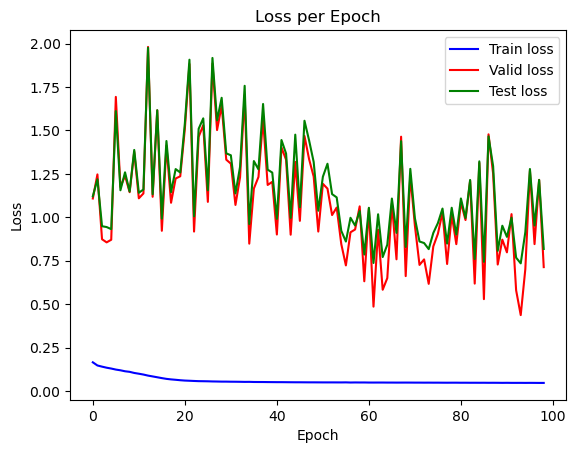

In [ ]:
start_epoch = 1

plt.plot(loss_history_tr[start_epoch:], "b-", label="Train loss")
plt.plot(loss_history_val[start_epoch:], "r-", label="Valid loss")
plt.plot(loss_history_te[start_epoch:], "g-", label="Test loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Inference - Making Predictions

Here, the model is put into evaluation mode and inference is done on the test set.

In [ ]:
# Set the best model to the specified device (e.g., GPU or CPU)
best_model.to(dev)

# Initialize lists to store input, labels, and model outputs
inputte = []
labeltte = []
outputte = []

# Put the best_model in evaluation mode (no gradient computation)
best_model.eval()

# Disable gradient computation for the following block
with torch.no_grad():
    sum_loss_te = 0

    # Iterate over batches in the test data loader
    for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)):
        # Move labels to the specified device
        label = batch[2].to(device)

        # Append input data to the inputte list and move it to the device
        inputte.append(batch[0].to(device))
        inp = batch[0].to(device)

        # Move target data to the device
        target = batch[1].to(device)

        # Pass the input data through the best_model to get predictions
        output = best_model(
            inp.float(),
            target.float(),
            batch_size=batch_size,
            steps_in=steps_in,
            steps_out=steps_out,
            tf_prob=0,
        )

        # Append the model's output to the outputte list
        outputte.append(output)

        # Calculate the current loss using a loss function
        current_loss = loss_function(output, label)

        # Append the labels to the labeltte list
        labeltte.append(label)

        # Calculate and accumulate the squared loss for this batch
        sum_loss_te += (current_loss.item() ** 2) * batch_size

    # Calculate the square root of the mean squared loss for the entire test dataset
    curr_te_loss = np.sqrt(sum_loss_te / len(test_dl))

    # Append the current test loss to a loss history list
    loss_history_te.append(curr_te_loss)

    # Print the current test loss
    print("curr_te_loss: ", curr_te_loss)


100%|██████████| 125/125 [00:06<00:00, 20.55it/s]

curr_te_loss:  0.7347670664056167


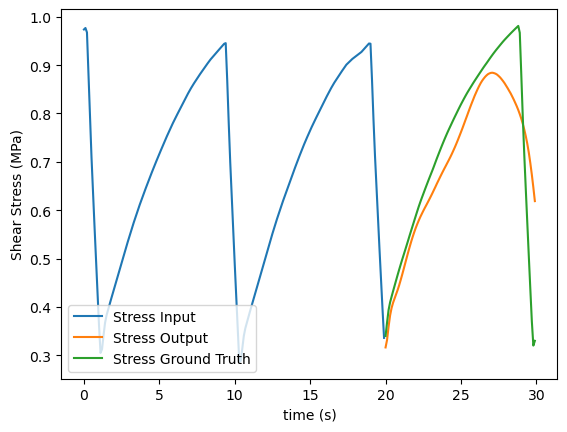

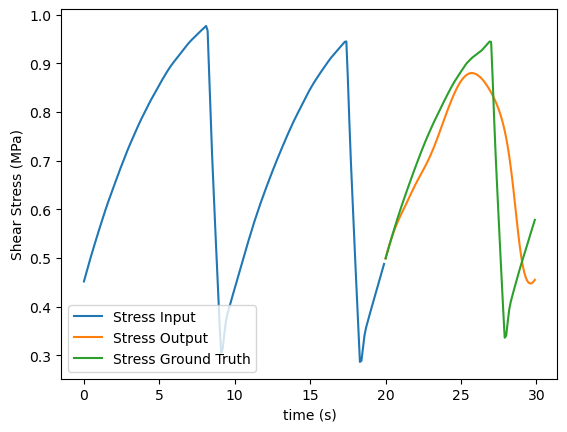

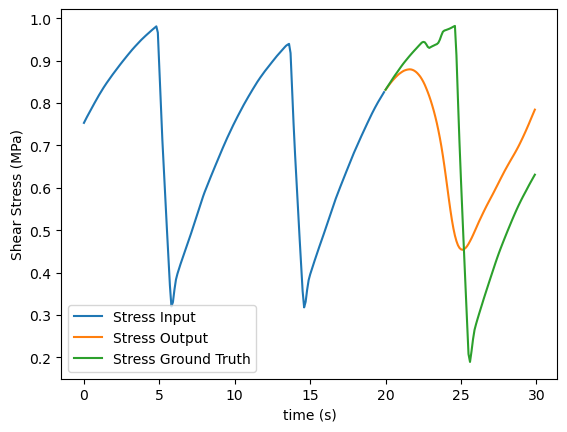

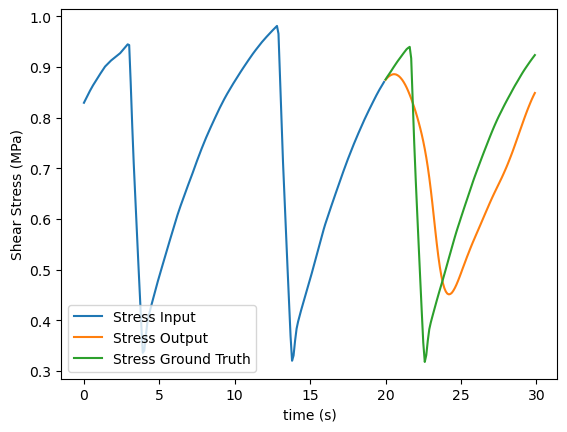

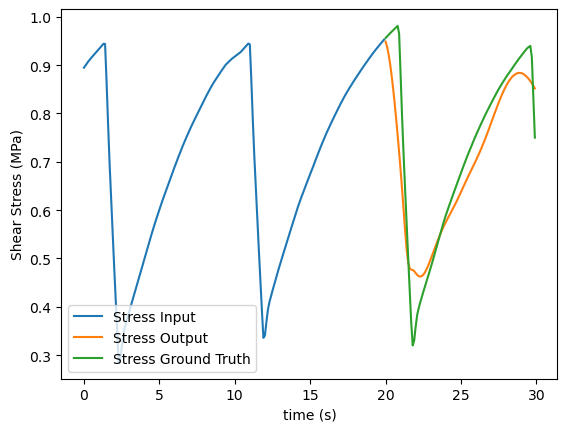

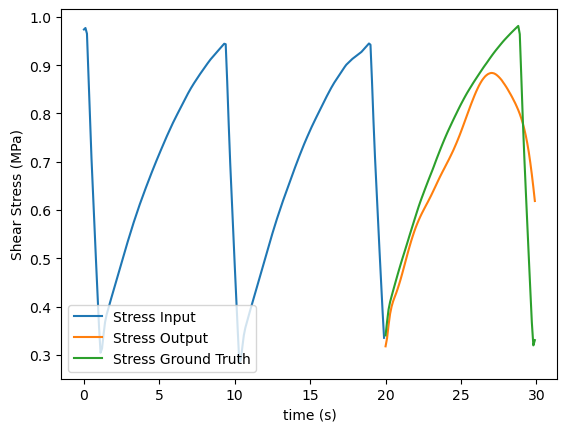

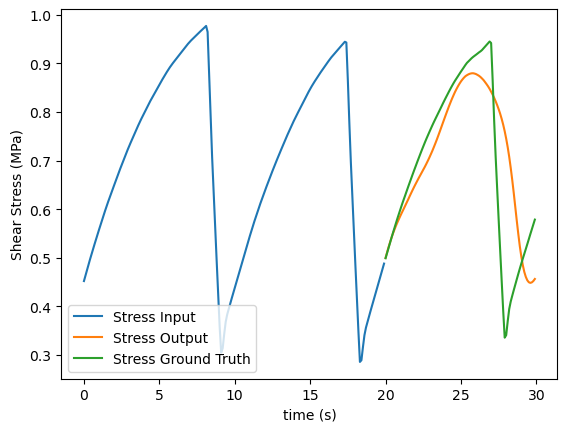

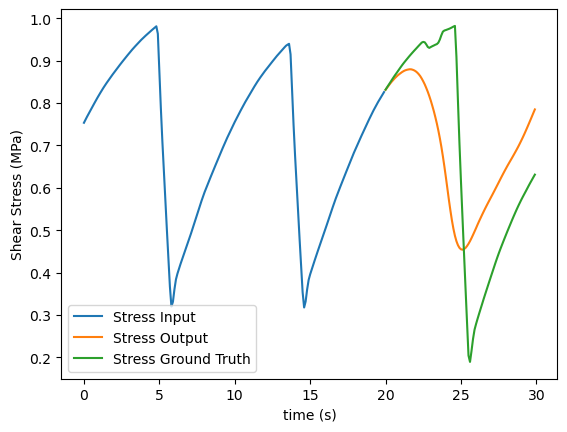

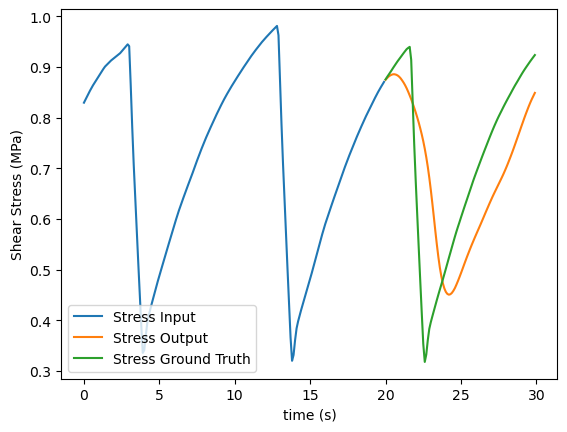

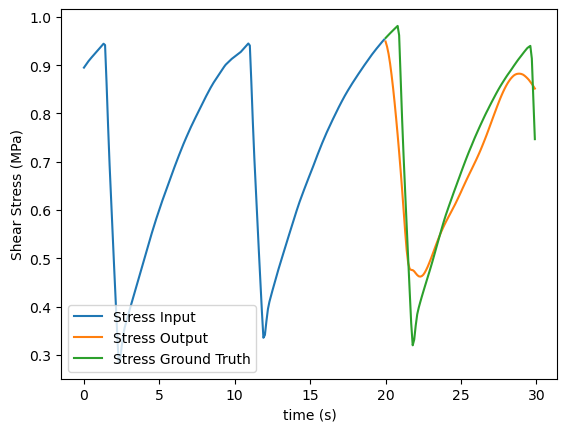

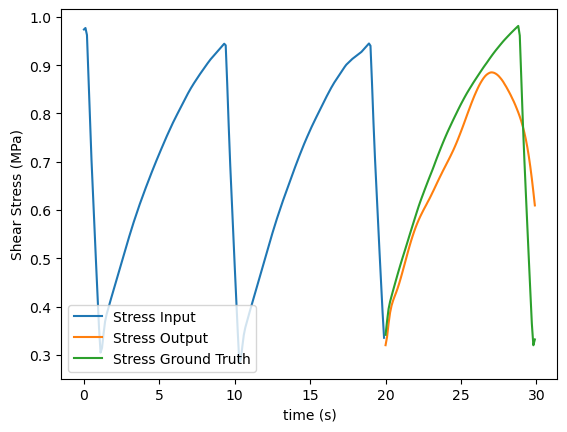

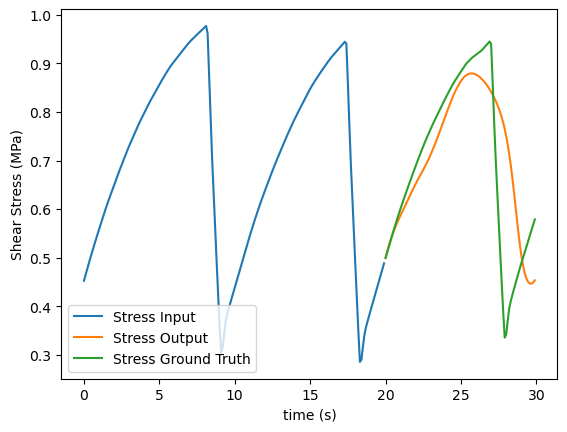

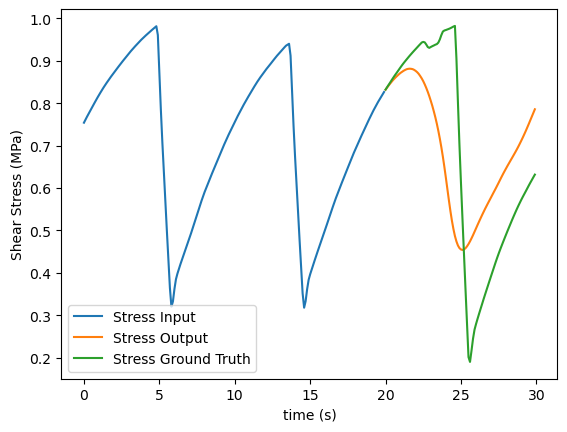

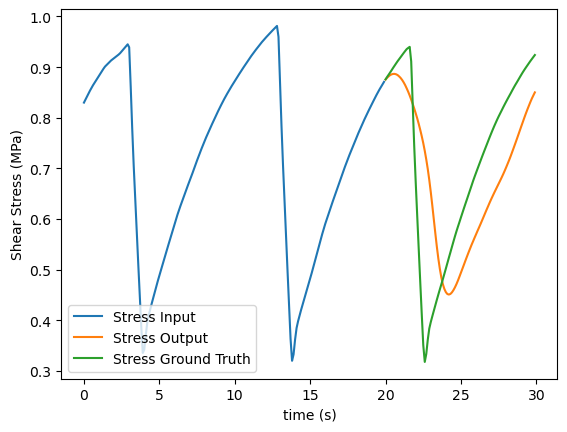

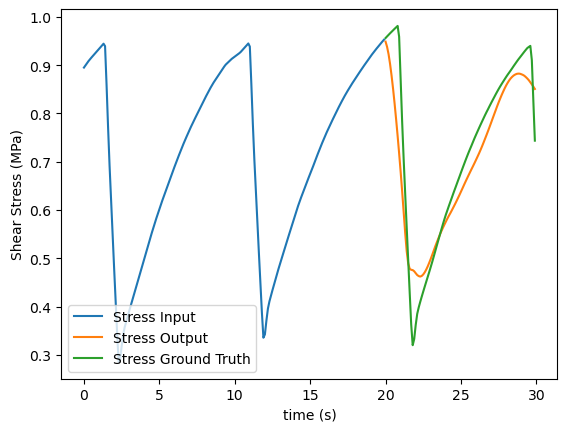

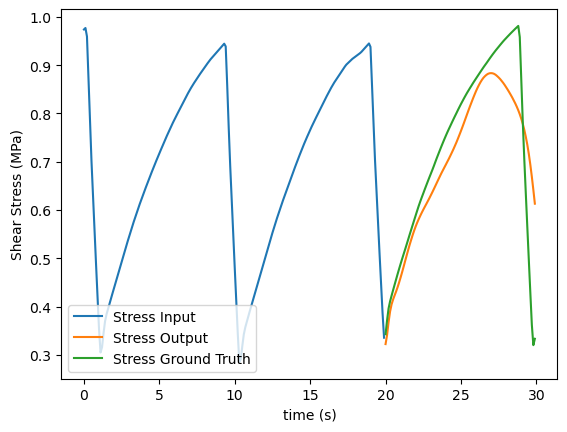

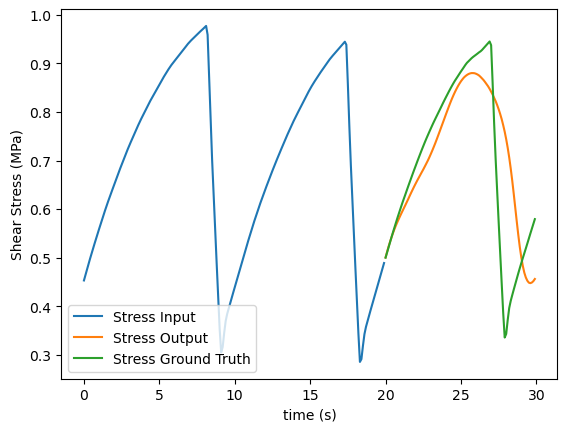

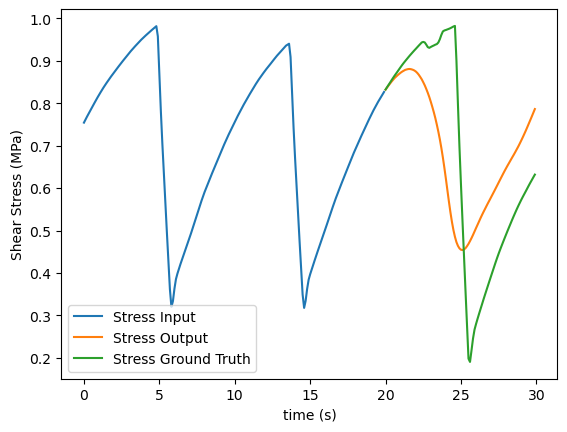

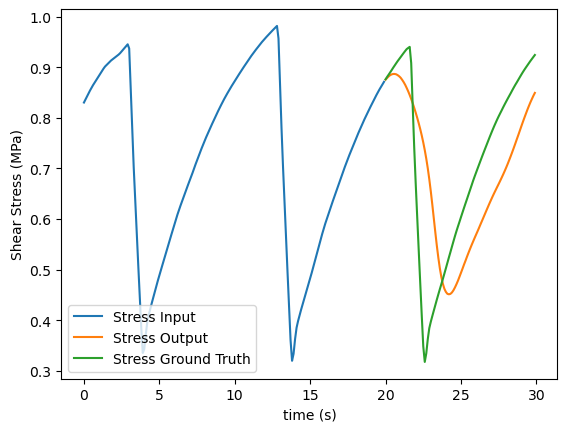

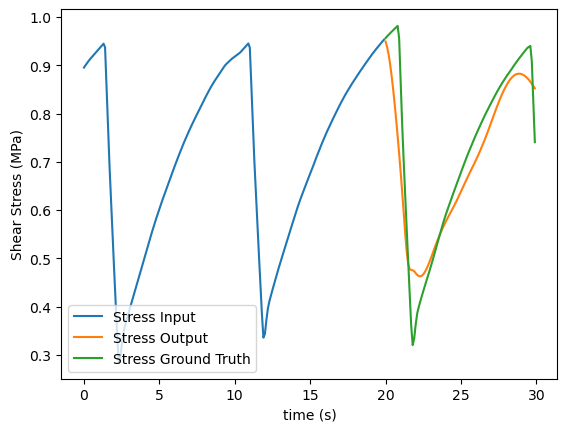

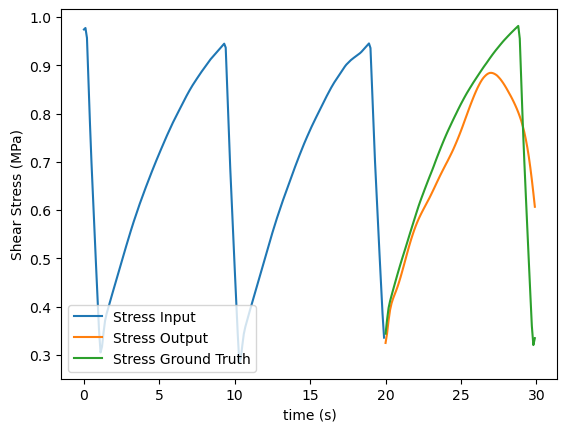

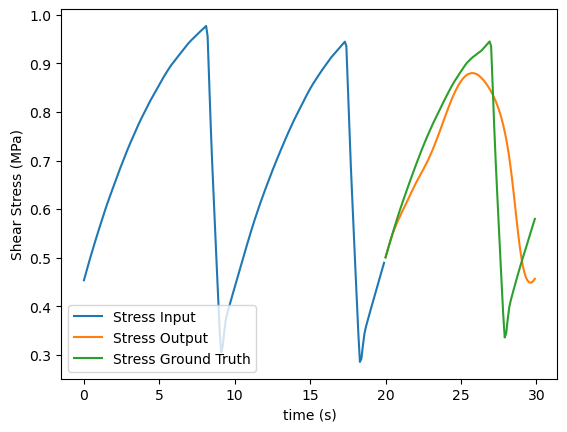

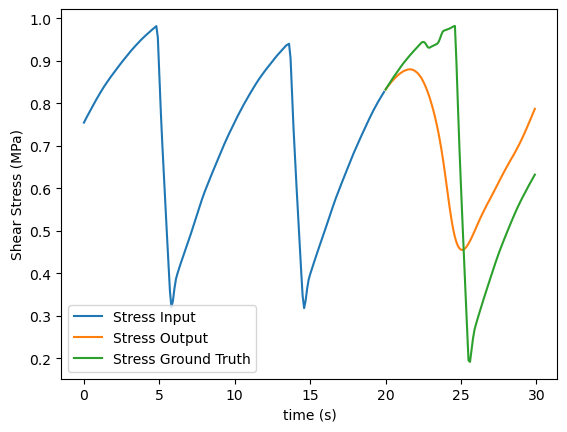

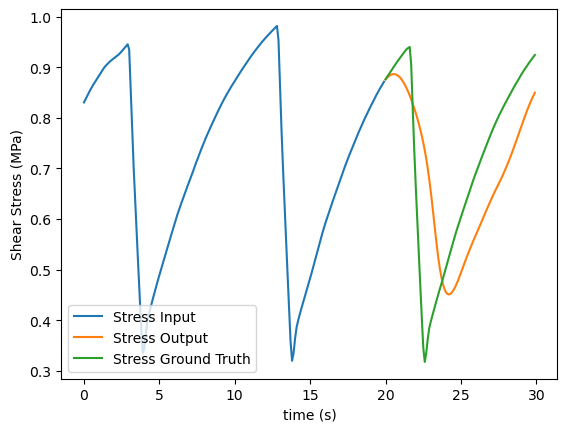

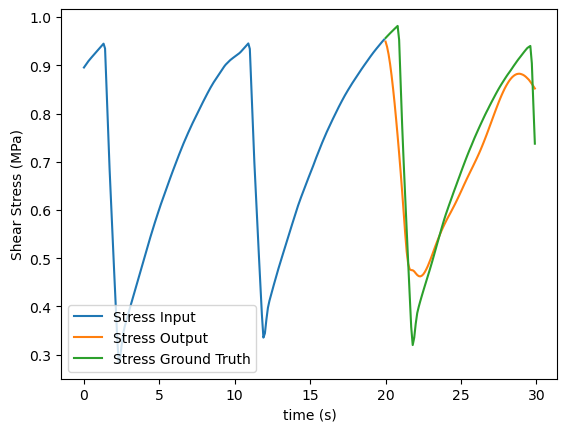

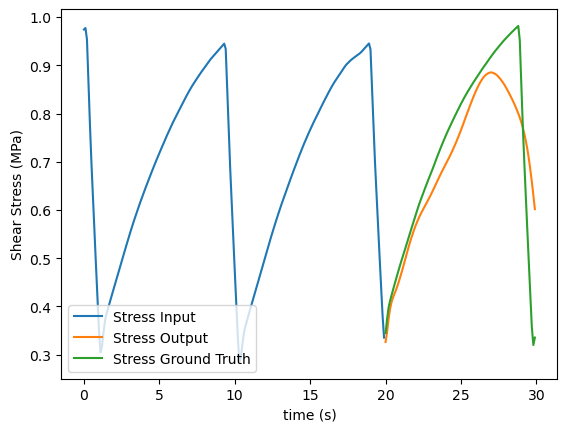

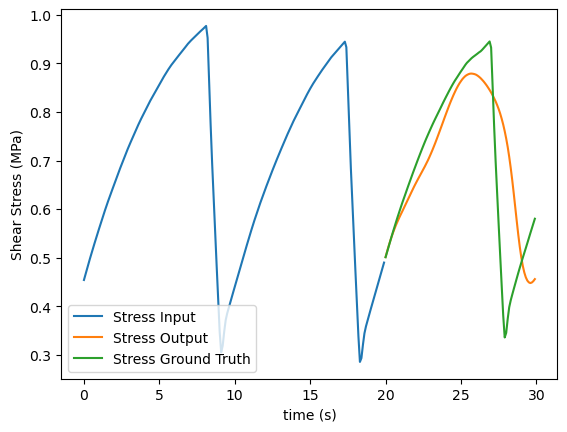

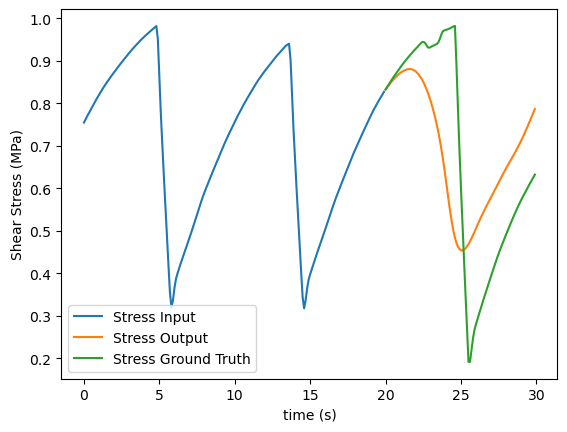

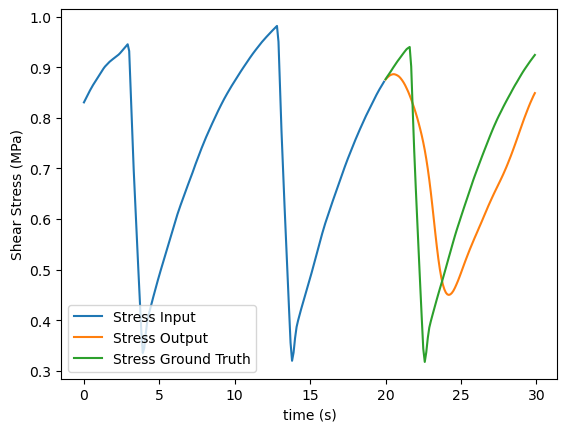

In [ ]:
wndw = 20
for btch in range(1, 30):
    plt.plot(
        [r * 0.1 for r in range(0, steps_in)],
        inputte[btch][wndw].cpu(),
        label="Stress Input",
    )
    plt.plot(
        [r * 0.1 for r in range(steps_in, steps_in + steps_out)],
        outputte[btch][wndw].cpu(),
        label="Stress Output",
    )
    plt.plot(
        [r * 0.1 for r in range(steps_in, steps_in + steps_out)],
        labeltte[btch][wndw].cpu(),
        label="Stress Ground Truth",
    )
    plt.xlabel("time (s)")
    plt.ylabel("Shear Stress (MPa)")
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
r_square_avg = 0
rmse_square_avg = 0
for w in range(len(outputte)):
    for b in range(0, batch_size):
        r_square = r2_score(outputte[w][b].cpu(), labeltte[w][b].cpu())
        rmse = sqrt(
            mean_squared_error(outputte[w][b].cpu(), labeltte[w][b].cpu())
        )
        r_square_avg += r_square
        rmse_square_avg += rmse
r_square_avg = r_square_avg / (len(outputte) * batch_size)
rmse_square_avg = rmse_square_avg / (len(outputte) * batch_size)

print("r_square_avg: ", r_square_avg, " rmse_square_avg: ", rmse_square_avg)

r_square_avg:  0.18542101457127197  rmse_square_avg:  0.12359879026436772
